In [2]:
from itertools import permutations, product

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std

import pickle

from ctgan import CTGANSynthesizer

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict

z = False
try:
    %cd ../utils
except:
    z=True
import model_utils
import validation_utils
if z:
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project/train_and_vis


In [3]:
df = pd.read_csv('data/info.csv')

In [4]:
isZoonotic = df.loc[df['isZoonotic']==1][:1200]
isZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(isZoonotic)

posGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
posGanModel.fit(isZoonotic)

# check if current model is better than pickled model
posGanModel.save('models/curr_models/posGanModel.pkl')

          cctg      gtgt      acac      ccga      ttga      accg      ctca  \
0     0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
1     0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
2     0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
3     0.367347  0.857143  0.469388  0.040816  0.295918  0.081633  0.081633   
4     0.483871  0.451613  0.580645  0.494624  0.311828  0.677419  0.129032   
...        ...       ...       ...       ...       ...       ...       ...   
1195  0.341772  0.265823  0.379747  0.101266  0.582278  0.126582  0.202532   
1196  0.368421  0.394737  0.513158  0.052632  0.500000  0.092105  0.236842   
1197  0.678571  0.797619  0.535714  0.071429  0.250000  0.166667  0.107143   
1198  0.549451  0.791209  0.527473  0.153846  0.296703  0.098901  0.087912   
1199  0.414634  0.292683  0.365854  0.060976  0.487805  0.158537  0.134146   

          tgtt      agcc      cgtt  ...      tggg      aata    

KeyboardInterrupt: 

In [50]:
notZoonotic = df.loc[df['isZoonotic']==0][:3000]
notZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(notZoonotic)

negGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
negGanModel.fit(notZoonotic)
negGanModel.save('models/curr_models/negGanModel.pkl')

          tggc      ttcc      tatg  ...      cttg      ctat      tctt
0     0.329787  0.297872  0.617021  ...  0.148936  0.393617  0.170213
1     0.377551  0.255102  0.744898  ...  0.153061  0.367347  0.112245
2     0.462366  0.279570  0.161290  ...  0.182796  0.193548  0.118280
3     0.455446  0.188119  0.475248  ...  0.188119  0.386139  0.138614
4     0.666667  0.333333  0.575758  ...  0.636364  0.515152  0.424242
...        ...       ...       ...  ...       ...       ...       ...
1195  0.404762  0.333333  0.571429  ...  0.261905  0.357143  0.202381
1196  0.417582  0.252747  0.637363  ...  0.208791  0.274725  0.153846
1197  0.341463  0.146341  0.329268  ...  0.207317  0.231707  0.231707
1198  0.192308  0.153846  0.461538  ...  0.166667  0.320513  0.230769
1199  0.226190  0.273810  0.428571  ...  0.166667  0.357143  0.285714

[1200 rows x 256 columns]
Epoch 1, Loss G:  1.8207,Loss D: -5.4888
Epoch 2, Loss G: -1.7336,Loss D: -0.0555
Epoch 3, Loss G: -1.9224,Loss D:  1.3800
Epoch 4, L

In [7]:
"""
n_syntheticPos = 100
n_syntheticNeg = 100

# consider storing NON-normalized data in CSV? Then calculate normalized values later for more accuracy
# generate sythetic labeled data
x_orig= pd.concat([negGanModel.sample(n_syntheticNeg), posGanModel.sample(n_syntheticPos)], axis=0, ignore_index=True)

y_orig = pd.concat([pd.DataFrame(np.zeros(n_syntheticNeg)), pd.DataFrame(np.ones(n_syntheticPos))], axis=0, ignore_index=True)


X_vals = pd.concat([df.loc[:, df.columns != 'isZoonotic'], x_orig], axis=0, ignore_index=True)
Y_vals = pd.concat([df['isZoonotic'], y_orig], axis=0, ignore_index=True)
"""

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.2, random_state=1)
# for col in df.columns:
#     col != 'isZoonotic' and X_train[col].isnull().sum() != 0 and print(X_train[col].isnull().sum())

y_train = y_train.values.ravel()

y_test = y_test.values.ravel()


In [4]:
print(len(X_train)+len(X_test))

9430


In [8]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32, 16),activation="relu",random_state=1)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)
print(clf.score(X_test, y_test))

0.953340402969247


In [9]:
pickle.dump(clf, open('models/curr_models/mlpClassifier.pkl', 'wb'))

In [10]:
# print(vu.cross_validate_gradBoost())
# print(vu.cross_validate_XGBoost())

val_utils.cross_validate_normal(clf, X_test, y_test)

Accuracy: 0.936 (0.020)


In [8]:
lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(X_train, y_train)

model_utils.(lrmodel, "lrmodel", X_test, y_test, dir='models/misc')

NameError: name 'saveModel' is not defined

In [6]:
# all 0s for some reason
predictions = lrmodel.predict(X_test)
picklething = pickle.load(open('models/curr_models/lrmodel.pkl', 'rb'))
print(accuracy_score(y_test, predictions), accuracy_score(y_test, picklething.predict(X_test)))

NameError: name 'lrmodel' is not defined

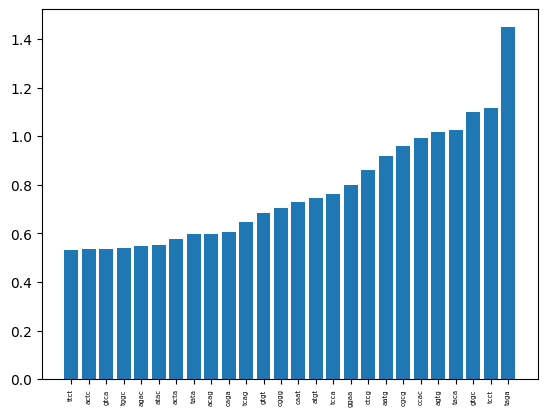

In [17]:
results = lrmodel.coef_[0]

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=5)

plt.bar([x[0] for x in res[230:]], [x[1] for x in res[230:]])
plt.show()

In [109]:
def getRealLength(kmer):
    print(X_test.iloc[0])
    sums = [kmer-1+((X_test.iloc[x].sum())/kmer) for x in range(len(X_test))]
    print(sums)

In [12]:
knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# knn = KNeighborsClassifier(n_neighbors=5)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [13]:
predictions = knntest.predict(X_test)
print(predictions[:10])
print(accuracy_score(y_test, predictions))
saveModel(knntest, "knn", X_test, y_test)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.8934252386002121


NameError: name 'saveModel' is not defined

In [14]:
randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [16]:

predictions = randforest.predict(X_test)
print(vu.cross_validate_normal(randforest, X_test, y_test))

saveModel(randforest, "randforest", X_test, y_test)

# for i in range(1000):
#     predictions[i] != y_test_list[i] and print(predictions[i], "vs", y_test_list[i])

Accuracy: 0.904 (0.023)
None


NameError: name 'saveModel' is not defined

In [22]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.9294803817603393


In [38]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":120, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8
    # "warm_start":True
}


# careful with WARM START - only works after a lot of iterations
for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
    )

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    cols_when_model_builds = gradBoost.feature_names_in_
    X_test=X_test[cols_when_model_builds]
    
    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True, dir="models/synthetic_data_testing")

Learning rate:  0.05
Accuracy score (validation): 0.957
no update
curr 0.9565217391304348 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.075
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.1
Accuracy score (validation): 0.956
no update
curr 0.9559915164369035 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.15
Accuracy score (validation): 0.960
no update
curr 0.9602332979851538 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.2
Accuracy score (validation): 0.963
no update
curr 0.9628844114528102 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.25
Accuracy score (validation): 0.958
no update
curr 0.9575821845174973 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.3
Accuracy score (validation): 0.958
no update
curr 0.9575821845174973 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.35
Accuracy score 

In [39]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "subsample":0.8,
    'lambda': 0.5, # regularization?
    'alpha': 0.5
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    # ALWAYS reset feature names
    cols_when_model_builds = xgBoost.get_booster().feature_names
    X_test=X_test[cols_when_model_builds]

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True, dir="models/synthetic_data_testing")

Learning rate:  0.05
Accuracy score (validation): 0.960
no update
curr 0.9602332979851538 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.075
Accuracy score (validation): 0.962
no update
curr 0.9623541887592789 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.1
Accuracy score (validation): 0.962
no update
curr 0.9618239660657476 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.15
Accuracy score (validation): 0.963
no update
curr 0.9634146341463414 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.2
Accuracy score (validation): 0.966
no update
curr 0.9655355249204666 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.25
Accuracy score (validation): 0.963
no update
curr 0.9634146341463414 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.3
Accuracy score (validation): 0.961
no update
curr 0.9612937433722163 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.35
Accuracy score 

In [17]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

best_xgboost = pickle.load(open('models/curr_models/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open('models/curr_models/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open('models/curr_models/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open('models/curr_models/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('models/curr_models/randforest.pkl', 'rb'))
mlp = pickle.load(open('models/curr_models/mlpClassifier.pkl', 'rb'))


print(best_xgboost_params)
print(best_gradBoost_params)
origX = X_test

nardus_gradBoost = pickle.load(open(f'models/nardus_gridsearch.pkl', 'rb'))

cols_when_model_builds = nardus_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print(len(X_test))
print("Best nardus GBM Accuracy: ", accuracy_score(y_test, nardus_gradBoost.predict(X_test)))
print("Balanced nardus GBM Accuracy: ", balanced_accuracy_score(y_test, nardus_gradBoost.predict(X_test)))
print(confusion_matrix(y_test, nardus_gradBoost.predict(X_test)).ravel())

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())


cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)))


print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))
print(confusion_matrix(y_test, best_rF.predict(X_test)).ravel())

print("Best mlp Accuracy: ", accuracy_score(y_test, mlp.predict(X_test)))
print("Balanced mlp Accuracy: ", balanced_accuracy_score(y_test, mlp.predict(X_test)))
print(confusion_matrix(y_test, mlp.predict(X_test)).ravel())


{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'subsample': 0.8, 'lambda': 0.5, 'alpha': 0.5, 'learning_rate': 0.25}
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
1886
Best nardus GBM Accuracy:  0.9777306468716861
Balanced nardus GBM Accuracy:  0.9300917021235259
[1626    8   34  218]
Best XG Accuracy:  0.9920466595970308
Balanced XG Accuracy:  0.97359435410231
[1631    3   15  237]
Best GB Accuracy:  0.9904559915164369
Balanced GB Accuracy:  0.9693201025820365
[1631    3   15  237]
[[1631    3]
 [  15  237]]
Best rF Accuracy:  0.8552492046659597
Balanced rF Accuracy:  0.49525218083969613
[1612   22  251    1]
Best mlp Accuracy:  0.8568398727465536
Balanced mlp Accuracy:  0.4944920440636475
[1616   18  252    0]


precision recall: 0.9866752433527054
[6.96492584e-03 1.38793020e-03 8.93577784e-04 ... 1.40547567e-03
 1.94242149e-03 9.17914786e-01]


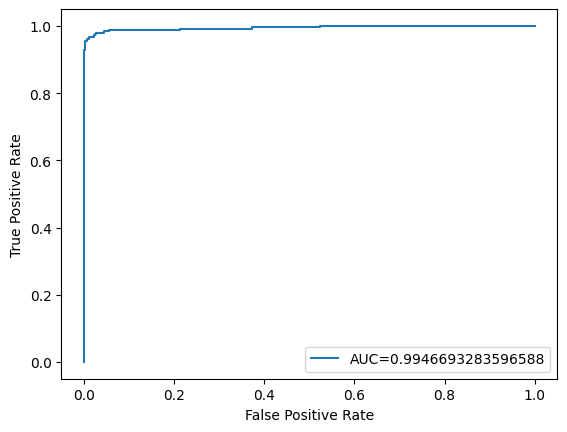

In [18]:
# ALWAYS reset X columns to the right order
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

y_thing = y_test
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


precision recall: 0.11611509701735998
[2.66661940e-08 1.01721114e-08 4.54365800e-07 ... 1.07526615e-06
 6.97629527e-07 5.72673889e-07]


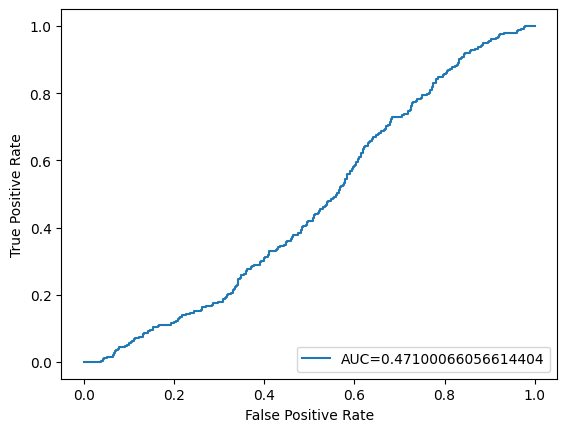

In [19]:
# ALWAYS reset X columns to the right order

y_thing = y_test
precision, recall, thresholds = precision_recall_curve(y_thing, mlp.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = mlp.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


precision recall: 0.9607981856872869
[0.00582382 0.00151332 0.00109172 ... 0.00140075 0.00179154 0.96858333]


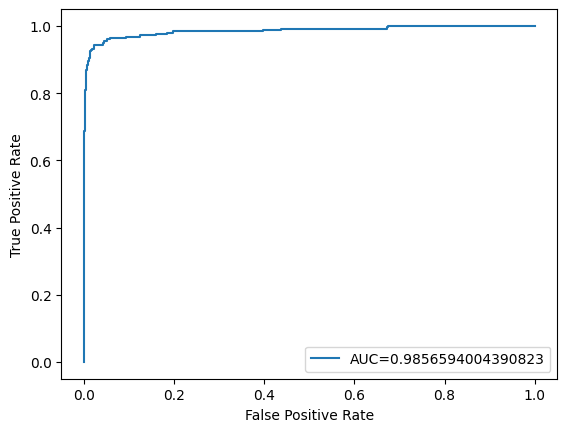

In [15]:
# ALWAYS reset X columns to the right order
cols_when_model_builds = nardus_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

y_thing = y_test
precision, recall, thresholds = precision_recall_curve(y_thing, nardus_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = nardus_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


precision recall: 0.9853873015806424
[9.9809328e-04 8.7908549e-05 7.8032710e-05 ... 2.4402520e-04 3.1285256e-04
 8.8636583e-01]


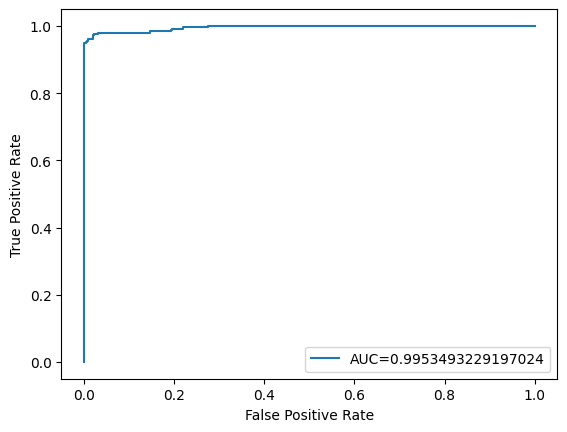

In [10]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

y_thing = y_test
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_xgboost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [24]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(nardus_gradBoost.best_estimator_, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.947 (0.014)


In [20]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mlp, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.940 (0.018)


In [22]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_xgboost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.946 (0.011)


In [21]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.948 (0.014)


In [25]:
y_pred_proba = best_rF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)
y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)

print(aaa)
print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [26]:
y_pred_proba = lrmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

NameError: name 'lrmodel' is not defined

In [16]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.900 (0.023)


In [15]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lrmodel, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

NameError: name 'lrmodel' is not defined

In [14]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(knntest, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

NameError: name 'knntest' is not defined